# Statistical Considerations in Test
主要分成兩個主題
1. 統計如何幫助我們設置檢驗
2. 分析檢驗時的常見誤區

# Statistical Significance
本節使用的情況是測驗改變網頁的排版是否會增加點擊下載的比率，控制組與實驗組利用 cookie 分割，且只記錄兩件事
1. 網頁版本，0 為控制組，1 為實驗組
2. 使否在資料收集階段點擊了下載鈕

在做檢驗時要考慮以下兩點
- Invariant metric - 比如說兩組的資料筆數是否類似，這對於我們最後利用Evaluation Metric得到的推論很重要，這一步能確保檢驗的基礎是可靠的。
- Evaluation Metric - 真正要假設檢驗的東西。

In [1]:
# import packages
import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.stats import proportion as proptests

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import data
data = pd.read_csv('../data/statistical_significance_data.csv')
data.head()

,condition,click
0,1,0
1,0,0
2,0,0
3,1,1
4,1,0


## Invariant metric
### Simulation-base
分類次數是訪問者的人數，假設我們預期50%/50%分類，將試驗重複200000次（兼具速度與變異性），看看之中有幾次屬於50%/50%分類的極端。
由於我們做得是雙尾測試，極端狀況也包括50%/50%分類的另一端，也就是說如果結果0.48和更小的值視為極端，則0.52和更大的值也視為極端，藉此計算 p-value。

$$H_0: \pi_{ctrl} = 0.5$$
$$H_1: \pi_{ctrl} \neq 0.5$$

In [3]:
# get number of trials and number of 'successes'
n_obs = data.shape[0]
n_ctrl = data[data.condition == 0].shape[0]

In [4]:
# simulate outcomes under null
n_trials = 200000
prob = 0.5
np.random.seed(42)
null_dist = np.random.binomial(n_obs, prob, n_trials)

0.613205

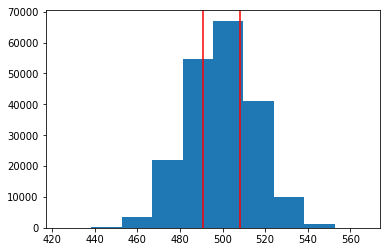

In [5]:
# compare to observed outcome
plt.hist(null_dist)
plt.axvline(n_ctrl, color='r')
plt.axvline(n_obs - n_ctrl, color='r');

p_value = (null_dist <= n_ctrl).mean() + (null_dist >= n_obs - n_ctrl).mean()
p_value

### Analytic Approach

可以使用二項式分布來計算 p-value，但更常見的是使用常態分布（因為central limit theorem），為了得到更準確的值，記得要做 continuity correction，可以在計算曲線下面積前加或減去 0.5，也就是說如果控制組比率為 415/850，常態近似就是左邊的面積 (415+0.5)/850=0.489，右邊的面積 (435−0.5)/850=0.511。

In [6]:
# get number of trials and number of 'successes'
n_obs = data.shape[0]
n_control = data.groupby('condition').size()[0]

In [7]:
# Compute a z-score and p-value
p = 0.5
sd = np.sqrt(p * (1-p) * n_obs)

z = ((n_control + 0.5) - p * n_obs) / sd

print(z)
print(2 * stats.norm.cdf(z))

-0.5062175977346661
0.6127039025537114


> 可以看出 p-value 很大，所以我們無法拒絕 null，因此可以安心進行Evaluation Metric的測試

## Evaluation Metric

$$H_0: CTR_{exp} - CTR_{ctrl} <= 0$$
$$H_1: CTR_{exp} - CTR_{ctrl} > 0$$

In [8]:
p_click = data.groupby('condition').mean()['click']
p_click

condition
0    0.079430
1    0.112205
Name: click, dtype: float64

### Simulation-base

In [9]:
# get number of trials and overall 'success' rate under null
n_control = data.groupby('condition').size()[0]
n_exper = data.groupby('condition').size()[1]
p_null = data['click'].mean()

In [10]:
# simulate outcomes under null, compare to observed outcome
n_trials = 200000

ctrl_clicks = np.random.binomial(n_control, p_null, n_trials)
exp_clicks = np.random.binomial(n_exper, p_null, n_trials)
samples = exp_clicks / n_exper - ctrl_clicks / n_control

print((samples >= (p_click[1] - p_click[0])).mean())

0.0397


### Analytic Approach

In [11]:
# compute standard error, z-score, and p-value
se_p = np.sqrt(p_null * (1-p_null) * (1/n_control + 1/n_exper))

z = (p_click[1] - p_click[0]) / se_p
print(z)
print(1-stats.norm.cdf(z))

1.7571887396196666
0.039442821974613684


> 可以看出上面的結果拒絕 null，因此新的排版在統計上比舊的還好。

## Experiment Size
我們可以利用我們想要的實際顯著邊界來設計實驗，只要知道需要多少觀察數才能在我們想要的信賴標準下看到預期的效果，就可以知道實驗需要多少時間。

這裡舉基礎 CTR 為 10% 而我們想要成長到 12% 的例子，看看在每一組中需要多少觀察樹才能在 Type I error rate 為 $\alpha = .05$? 的情況下觀察到變化具有 power $1-\beta = .80$ (也就是說在80%的時間下都能觀察到實際成長2%)

### Method 1: Trial and error
其中一個方法是藉由 Trial and error，每一個 sample size 會有相對應的 level of power，測試不同樣本大小能幫助我們逐漸找到能滿足預期 power level 的最小樣本大小，這雖然不是最有效的方法但可以讓我們看看決定實驗大小實際是怎麼運作的。

下方的 `power()` 函式是由以下步驟完成的:
1. 在 null 假設下，我們可以找到一個臨界值讓 Type 1 error rate 滿足我們想要的 alpha level
    - `se_null`: 計算在 null 假設下兩個組別比例差別的標準差，基礎機率為 `p_null`，記得差分佈（difference distribution）的變異數為兩個分佈個別的變異數和，且每個組別的觀察數為 `n`。
    - `null_dist`: 為了可以重複利用，這個應該是一個[scipy norm object](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)。
    - `p_crit`: 計算能使我們拒絕 null 假設的臨界值。

2. Power 是在 alternative 假設下超過上面算出的臨界值的分布面積。
    - `se_alt`: 這次是計算想要的差別下的標準差，注意這次兩組別的成功機率不同了，一個是`p_null`，另一個則是`p_alt`
    - `alt_dist`: 和上面一樣是 scipy norm object，但要注意 loc ，因為這次 `p_alt` 要比 `p_null` 大。
    - `beta`: Beta 是 Type-II error 的機率 (或是在特定 non-null state 下無法拒絕 null 的機率)。

In [12]:
def power(p_null, p_alt, n, alpha = .05, plot = True):
    """
    Compute the power of detecting the difference in two populations with 
    different proportion parameters, given a desired alpha rate.
    
    Input parameters:
        p_null: base success rate under null hypothesis
        p_alt : desired success rate to be detected, must be larger than
                p_null
        n     : number of observations made in each group
        alpha : Type-I error rate
        plot  : boolean for whether or not a plot of distributions will be
                created
    
    Output value:
        power : Power to detect the desired difference, under the null.
    """
    
    # Compute the power
    se_null = np.sqrt((p_null * (1-p_null) + p_null * (1-p_null)) / n)
    null_dist = stats.norm(loc = 0, scale = se_null)
    p_crit = null_dist.ppf(1 - alpha)
    
    se_alt = np.sqrt((p_null * (1-p_null) + p_alt * (1-p_alt)) / n)
    alt_dist = stats.norm(loc = p_alt - p_null, scale = se_alt)
    beta = alt_dist.cdf(p_crit)
    
    if plot:
        # Compute distribution heights
        low_bound = null_dist.ppf(.01)
        high_bound = alt_dist.ppf(.99)
        x = np.linspace(low_bound, high_bound, 201)
        y_null = null_dist.pdf(x)
        y_alt = alt_dist.pdf(x)

        # Plot the distributions
        plt.plot(x, y_null)
        plt.plot(x, y_alt)
        plt.vlines(p_crit, 0, np.amax([null_dist.pdf(p_crit), alt_dist.pdf(p_crit)]),
                   linestyles = '--')
        plt.fill_between(x, y_null, 0, where = (x >= p_crit), alpha = .5)
        plt.fill_between(x, y_alt , 0, where = (x <= p_crit), alpha = .5)
        
        plt.legend(['null','alt'])
        plt.xlabel('difference')
        plt.ylabel('density')
        plt.title(f'n: {n}')
        plt.show()
    
    # return power
    return (1 - beta)

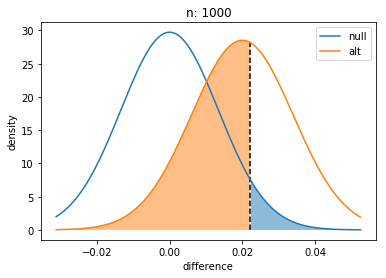

0.44122379261151545

In [13]:
power(.1, .12, 1000)

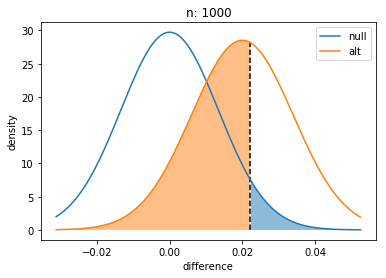

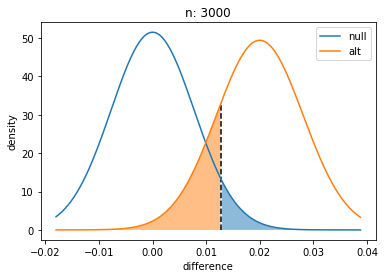

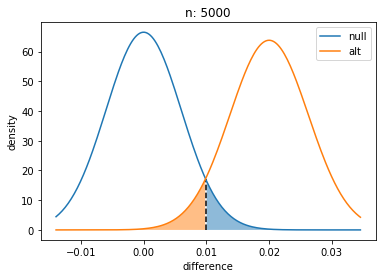

You should see this message if all the assertions passed!


In [14]:
assert np.isclose(power(.1, .12, 1000, plot = True), 0.4412, atol = 1e-4)
assert np.isclose(power(.1, .12, 3000, plot = True), 0.8157, atol = 1e-4)
assert np.isclose(power(.1, .12, 5000, plot = True), 0.9474, atol = 1e-4)
print('You should see this message if all the assertions passed!')

### Method 2: Analytic Solution

由上面我們大概對 power 有些概念了，現在可以來看看解析解。必須注意的一點是當$\alpha$ 和 $\beta$ 都小於 0.5 時，決定統計顯著的臨界值會落在null click-through rate 和 alternative, desired click-through rate 之間，所以　$p_0$ 和 $p_1$ 的差又可以進一步分成 $p_0$ 與臨界值 $p^*$ 的距離和 $p^*$ 到 $p_1$ 的距離，示意圖如下

<img src= 'https://viewvrgyb1g8sx9.udacity-student-workspaces.com/files/images/ExpSize_Power.png'>

這些進一步的區分可以用 standard error 和 z-scores 來表示

$$p^* - p_0 = z_{1-\alpha} SE_{0},$$
$$p_1 - p^* = -z_{\beta} SE_{1};$$

$$p_1 - p_0 = z_{1-\alpha} SE_{0} - z_{\beta} SE_{1}$$

而 standard errors 又可以表示成分布的標準差除以根號樣本數

$$SE_{0} = \frac{s_{0}}{\sqrt{n}},$$
$$SE_{1} = \frac{s_{1}}{\sqrt{n}}$$

把這些值帶進去我們就能求出 $n$ 為
$$n = \lceil \big(\frac{z_{\alpha} s_{0} - z_{\beta} s_{1}}{p_1 - p_0}\big)^2 \rceil$$

其中 $\lceil ... \rceil$ 為 ceiling function 無條件進位至下一個整數。

In [15]:
def experiment_size(p_null, p_alt, alpha = .05, beta = .20):
    """
    Compute the minimum number of samples needed to achieve a desired power
    level for a given effect size.
    
    Input parameters:
        p_null: base success rate under null hypothesis
        p_alt : desired success rate to be detected
        alpha : Type-I error rate
        beta  : Type-II error rate
    
    Output value:
        n : Number of samples required for each group to obtain desired power
    """
    
    # Get necessary z-scores and standard deviations (@ 1 obs per group)
    z_null = stats.norm.ppf(1 - alpha)
    z_alt  = stats.norm.ppf(beta)
    sd_null = np.sqrt(p_null * (1-p_null) + p_null * (1-p_null))
    sd_alt  = np.sqrt(p_null * (1-p_null) + p_alt  * (1-p_alt) )
    
    # Compute and return minimum sample size
    n = ((z_null * sd_null - z_alt * sd_alt) / (p_alt - p_null))**2
    return np.ceil(n)

In [16]:
experiment_size(.1, .12)

2863.0

In [17]:
assert np.isclose(experiment_size(.1, .12), 2863)
print('You should see this message if the assertion passed!')

You should see this message if the assertion passed!


上面的例子是單尾測試，且預設 alternative value 大於 null，所以在第一部份的方法在 alternative value 小於 null 的情況，第二部分的方法則不受影響。

如果想做雙尾測試則需要注意兩件事
1. $\alpha$ 需要考慮到得除以2的問題
2. 必須以最糟的情況來考慮，也就是 alternative 情況有最高的 variability，因為對 binomil 來說 variance 在 𝑝=.5 時最高，然後隨著 𝑝 接近 0 和 1 逐漸變小，所以要選擇盡量靠近 .5 的值來計算所需的樣本大小。

## Alternative Approaches

There are also tools and Python packages that can also help with sample sizing decisions, so you don't need to solve for every case on your own. The sample size calculator [here](http://www.evanmiller.org/ab-testing/sample-size.html) is applicable for proportions, and provides the same results as the methods explored above. (Note that the calculator assumes a two-tailed test, however.) Python package "statsmodels" has a number of functions in its [`power` module](https://www.statsmodels.org/stable/stats.html#power-and-sample-size-calculations) that perform power and sample size calculations. Unlike previously shown methods, differences between null and alternative are parameterized as an effect size (standardized difference between group means divided by the standard deviation). Thus, we can use these functions for more than just tests of proportions. If we want to do the same tests as before, the [`proportion_effectsize`](http://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_effectsize.html) function computes [Cohen's h](https://en.wikipedia.org/wiki/Cohen%27s_h) as a measure of effect size. As a result, the output of the statsmodel functions will be different from the result expected above. This shouldn't be a major concern since in most cases, you're not going to be stopping based on an exact number of observations. You'll just use the value to make general design decisions.

In [18]:
# example of using statsmodels for sample size calculation
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# leave out the "nobs" parameter to solve for it
NormalIndPower().solve_power(effect_size = proportion_effectsize(.12, .1), alpha = .05, power = 0.8,
                             alternative = 'larger')

3020.515856462414

# Non-Parametric Tests
前面做的都是建立在常態分佈下標準的假設檢驗，但有時候會遇到不確定分布的variability，資料量不足以保證常態分佈或想要對沒有標準測試的統計值做推斷的情況，這時候就需要 non-parametric 測試。其最主要的優勢在於它的可應用範圍很廣，以下就介紹幾種方法。

## Bootstrapping
使用實際收集到的資料來產生新的樣本以預測取樣分布，一般的 Bootstrapping 是指以有 replacement 的方式取樣到與原來資料一樣多的點，基本上就是把原始資料視為 population，但不對其分佈做假設。
多取幾次 bootstrapped samples 可以幫助我們推測很多原始資料的取樣分佈統計值，以下就以 95% confidence interval for the 90th percentile from a dataset of 5000 data points　為例。

其步驟為
- Initialize some useful variables by storing the number of data points in `n_points` and setting up an empty list for the bootstrapped quantile values in `sample_qs`.
- Create a loop for each trial:
  - First generate a bootstrap sample by sampling from our data with replacement. ([`random.choice`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html) will be useful here.)
  - Then, compute the `q`th quantile of the sample and add it to the `sample_qs` list. If you're using NumPy v0.15 or later, you can use the [`quantile`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.quantile.html) function to get the quantile directly with `q`; on v0.14 or earlier, you'll need to put `q` in terms of a percentile and use [`percentile`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html) instead.
- After gathering the bootstrapped quantiles, find the limits that capture the central `c` proportion of quantiles to form the estimated confidence interval.

In [19]:
def quantile_ci(data, q, c = .95, n_trials = 1000):
    """
    Compute a confidence interval for a quantile of a dataset using a bootstrap
    method.
    
    Input parameters:
        data: data in form of 1-D array-like (e.g. numpy array or Pandas series)
        q: quantile to be estimated, must be between 0 and 1
        c: confidence interval width
        n_trials: number of bootstrap samples to perform
    
    Output value:
        ci: Tuple indicating lower and upper bounds of bootstrapped
            confidence interval
    """
    
    # initialize storage of bootstrapped sample quantiles
    n_points = len(data) # number of data points
    sample_qs = [] # storage of sampled quantiles
    
    # For each trial...
    for _ in range(n_trials):
        # draw a random sample from the data with replacement...
        sample = data.sample(n_points, replace=True)
        
        # compute the desired quantile...
        sample_q = np.percentile(sample, 100 * q)
        
        # and add the value to the list of sampled quantiles
        sample_qs.append(sample_q)
        
    # Compute the confidence interval bounds
    lower_limit = np.percentile(sample_qs, (1 - c)/2 * 100)
    upper_limit = np.percentile(sample_qs, (1 + c)/2 * 100)
    
    return (lower_limit, upper_limit)

In [20]:
data = pd.read_csv('../data/bootstrapping_data.csv')
data.head(10)

,time
0,8152
1,2082
2,3049
3,3317
4,813
5,1442
6,3815
7,2113
8,738
9,2499


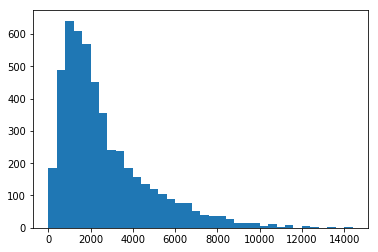

In [21]:
# data visualization
plt.hist(data['time'], bins = np.arange(0, data['time'].max()+400, 400));

In [22]:
lims = quantile_ci(data['time'], 0.9)
print(lims)

(5496.950000000001, 5837.0)


### Bootstrapping Notes

Confidence intervals coming from the bootstrap procedure will be optimistic compared to the true state of the world. This is because there will be things that we don't know about the real world that we can't account for, due to not having a parametric model of the world's state. Consider the extreme case of trying to understand the distribution of the maximum value: our confidence interval would never be able to include any value greater than the largest observed value and it makes no sense to have any lower bound below the maximum observation. Intuitively, however, there's a pretty clear possibility for there to be unobserved values that are larger than the one we've observed, especially for skewed data like shown in the example.

This doesn't override the bootstrap method's advantages, however. The bootstrap procedure is fairly simple and straightforward. Since you don't make assumptions about the distribution of data, it can be applicable for any case you encounter. The results should also be fairly comparable to standard tests. But it does take computational effort, and its output does depend on the data put in. For reference, for the 95% CI on the 90th percentile example explored above, the inferred interval would only capture about 83% of 90th percentiles from the original generating distribution. But a more intricate procedure using a binomial assumption to index on the observed data only does about one percentage point better (84%). And both of these depend on the specific data generated: a different set of 5000 points will produce different intervals, with different accuracies.

Binomial solution for percentile CIs reference: [1](https://www-users.york.ac.uk/~mb55/intro/cicent.htm), [2](https://stats.stackexchange.com/questions/99829/how-to-obtain-a-confidence-interval-for-a-percentile)

## Permutation Tests

The permutation test is a resampling-type test used to compare the values on an outcome variable between two or more groups. In the case of the permutation test, resampling is done on the group labels. The idea here is that, under the null hypothesis, the outcome distribution should be the same for all groups, whether control or experimental. Thus, we can emulate the null by taking all of the data values as a single large group. Applying labels randomly to the data points (while maintaining the original group membership ratios) gives us one simulated outcome from the null.

The rest is similar to the sampling approach used in a standard hypothesis test, except that we haven't specified a reference distribution to sample from – we're sampling directly from the data we've collected. After applying the labels randomly to all the data and recording the outcome statistic many times, we compare our actual, observed statistic against the simulated statistics. A p-value is obtained by seeing how many simulated statistic values are as or more extreme than the one actually observed, and a conclusion is then drawn.

Try implementing a permutation test in the cells below to test if the 90th percentile of times is statistically significantly smaller for the experimental group, as compared to the control group:

- Initialize an empty list to store the difference in sample quantiles as `sample_diffs`.
- Create a loop for each trial:
  - First generate a permutation sample by randomly shuffling the data point labels. ([`random.permutation`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.permutation.html) will be useful here.)
  - Then, compute the `q`th quantile of the data points that have been assigned to each group based on the permuted labels. Append the difference in quantiles to the `sample_diffs` list.
- After gathering the quantile differences for permuted samples, compute the observed difference for the actual data. Then, compute a p-value from the number of permuted sample differences that are less than or greater than the observed difference, depending on the desired alternative hypothesis.

In [23]:
def quantile_permtest(x, y, q, alternative = 'less', n_trials = 10_000):
    """
    Compute a confidence interval for a quantile of a dataset using a bootstrap
    method.
    
    Input parameters:
        x: 1-D array-like of data for dependent / output feature
        y: 1-D array-like of data for independent / grouping feature as 0s and 1s
        q: quantile to be estimated, must be between 0 and 1
        alternative: type of test to perform, {'less', 'greater'}
        n_trials: number of permutation trials to perform
    
    Output value:
        p: estimated p-value of test
    """
    
    
    # initialize storage of bootstrapped sample quantiles
    sample_diffs = []
    
    # For each trial...
    for _ in range(n_trials):
        # randomly permute the grouping labels
        labels = np.random.permutation(y)
        
        # compute the difference in quantiles
        cond_q = np.percentile(x[labels == 0], 100 * q)
        exp_q = np.percentile(x[labels == 1], 100 * q)
        sample_diff = exp_q - cond_q
        
        # and add the value to the list of sampled differences
        sample_diffs.append(sample_diff)
    
    # compute observed statistic
    cond_q = np.percentile(x[y == 0], 100 * q)
    exp_q  = np.percentile(x[y == 1], 100 * q)
    obs_diff = exp_q - cond_q
    
    # compute a p-value
    if alternative == 'less':
        hits = (sample_diffs <= obs_diff).sum()
    elif alternative == 'greater':
        hits = (sample_diffs >= obs_diff).sum()
    
    return (hits / n_trials)

In [24]:
data = pd.read_csv('../data/permutation_data.csv')
data.head(10)

,condition,time
0,0,5940
1,0,666
2,1,571
3,1,779
4,0,1928
5,0,3791
6,0,736
7,1,8482
8,0,4594
9,0,1171


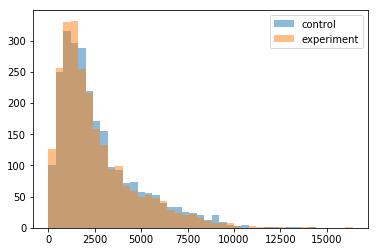

In [25]:
# data visualization
bin_borders = np.arange(0, data['time'].max()+400, 400)
plt.hist(data[data['condition'] == 0]['time'], alpha = 0.5, bins = bin_borders)
plt.hist(data[data['condition'] == 1]['time'], alpha = 0.5, bins = bin_borders)
plt.legend(labels = ['control', 'experiment']);

In [26]:
# Just how different are the two distributions' 90th percentiles?
print(np.percentile(data[data['condition'] == 0]['time'], 90),
      np.percentile(data[data['condition'] == 1]['time'], 90))

5809.199999999999 5492.2


In [27]:
quantile_permtest(data['time'], data['condition'], 0.9,
                  alternative = 'less')

0.0303

## Rank-Sum Test (Mann-Whitney)

The rank-sum test is fairly different from the two previous approaches. There's no resamplng involved; the test is performed only on the data present. The rank-sum test, also known as the Mann-Whitney U test, is not a test of any particular statistic, like the mean or median. Instead, it's a test of distributions: let's say we draw one value at random from the populations behind each group. The null hypothesis says that there's an equal chance that the larger value is from the first group as the second group; the alternative hypothesis says that there's an unequal chance, which can be specified as one- or two-tailed.

In order to test this hypothesis, we should look at the data we've collected and see in how many cases values from one group win compared to values in the second. That is, for each data point in the first group, we count how many values in the second group that are smaller than it. (If both values are equal, we count that as a tie, worth +0.5 to the tally.) This number of wins for the first group gives us a value $U$.

It turns out that $U$ is approximately normally-distributed, given a large enough sample size. If we have $n_1$ data points in the first group and $n_2$ points in the second, then we have a total of $n_1 n_2$ matchups and an equivalent number of victory points to hand out. Under the null hypothesis, we should expect the number of wins to be evenly distributed between groups, and so the expected wins are $\mu_U = \frac{n_1 n_2}{2}$. The variability in the number of wins can be found to be the following equation (assuming no or few ties):

$$ 
\sigma_U = \sqrt{\frac{n_1n_2(n_1+n_2+1)}{12}}
$$

These $\mu_U$ and $\sigma_U$ values can then be used to compute a standard normal z-score, which generates a p-value. Implement this method of performing the rank-sum test in the cells below!

- HINT: scipy stats' [`norm`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) class can be used to obtain p-values after computing a z-score.

In [28]:
def ranked_sum(x, y, alternative = 'two-sided'):
    """
    Return a p-value for a ranked-sum test, assuming no ties.
    
    Input parameters:
        x: 1-D array-like of data for first group
        y: 1-D array-like of data for second group
        alternative: type of test to perform, {'two-sided', less', 'greater'}
    
    Output value:
        p: estimated p-value of test
    """
    
    # compute U
    u = 0
    for i in x:
        wins = (i > y).sum()
        ties = (i == y).sum()
        u += wins + 0.5 * ties
    
    # compute a z-score
    n_1 = x.shape[0]
    n_2 = y.shape[0]
    mean_u = n_1 * n_2 / 2 # expected value for U statistic
    sd_u = np.sqrt(n_1 * n_2 * (n_1 + n_2 + 1) / 12) # expected standard deviation for U statistic
    z = (u - mean_u)/sd_u # U value z-score
    
    # compute a p-value
    if alternative == 'two-sided':
        p = 2 * stats.norm.cdf(-np.abs(z))
    if alternative == 'less':
        p = stats.norm.cdf(z)
    elif alternative == 'greater':
        p = stats.norm.cdf(-z)
    
    return p

In [29]:
data = pd.read_csv('../data/permutation_data.csv')
data.head(10)

,condition,time
0,0,5940
1,0,666
2,1,571
3,1,779
4,0,1928
5,0,3791
6,0,736
7,1,8482
8,0,4594
9,0,1171


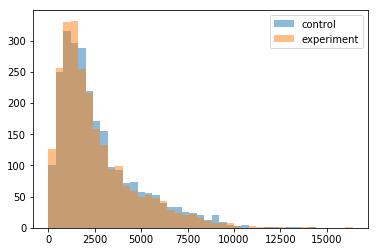

In [30]:
# data visualization
bin_borders = np.arange(0, data['time'].max()+400, 400)
plt.hist(data[data['condition'] == 0]['time'], alpha = 0.5, bins = bin_borders)
plt.hist(data[data['condition'] == 1]['time'], alpha = 0.5, bins = bin_borders)
plt.legend(labels = ['control', 'experiment']);

In [31]:
ranked_sum(data[data['condition'] == 0]['time'],
           data[data['condition'] == 1]['time'],
           alternative = 'greater')

0.001752226502296106

### Rank-Sum Test Notes

For smaller sample sizes, something like the permutation test can be performed. After exhaustively checking the distribution of victories for every possible assignment of group labels to value, a p-value can be computed for how unusual the actually-observed $U$ was.

Also, there already exists a function in the scipy stats package [`mannwhitneyu`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) that performs the Mann Whitney U test. This function considers more factors than the implementation above, including a correction on the standard deviation for ties and a continuity correction (since we're approximating a discretely-valued distribution with a continuous one). In addition, the approach they take is computationally more efficient, based on the sum of value ranks (hence the rank-sum test name) rather than the matchups explanation provided above.

Reference: [Wikipedia](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test)



In [32]:
stats.mannwhitneyu(data[data['condition'] == 0]['time'],
                   data[data['condition'] == 1]['time'],
                   alternative = 'greater')

MannwhitneyuResult(statistic=3273546.0, pvalue=0.001752280226004597)

## Sign Test

The sign test also only uses the collected data to compute a test result. It only requires that there be paired values between two groups to compare, and tests whether one group's values tend to be higher than the other's.

In the sign test, we don't care how large differences are between groups, only which group takes a larger value. So comparisons of 0.21 vs. 0.22 and 0.21 vs. 0.31 are both counted equally as a point in favor of the second group. This makes the sign test a fairly weak test, though also a test that can be applied fairly broadly. It's most useful when we have very few observations to draw from and can't make a good assumption of underlying distribution characteristics. For example, you might use a sign test as an additional check on click rates that have been aggregated on a daily basis.

The count of victories for a particular group can be modeled with the binomial distribution. Under the null hypothesis, it is equally likely that either group has a larger value (in the case of a tie, we ignore the comparison): the binomial distribution's success parameter is $p = 0.5$. Implement the sign test in the function below!

- HINT: scipy stats' [`binom`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html) class can be used to obtain p-values after computing the number of matchups and victories.

In [33]:
def sign_test(x, y, alternative = 'two-sided'):
    """
    Return a p-value for a ranked-sum test, assuming no ties.
    
    Input parameters:
        x: 1-D array-like of data for first group
        y: 1-D array-like of data for second group
        alternative: type of test to perform, {'two-sided', less', 'greater'}
    
    Output value:
        p: estimated p-value of test
    """
    
    # compute parameters
    n = x.shape[0] - (x == y).sum() # number of matchups
    k = (x > y).sum() - (x == y).sum() # number of victories for first group

    # compute a p-value
    if alternative == 'two-sided':
        p = min(1, 2 * stats.binom(n, 0.5).cdf(min(k, n-k)))
    if alternative == 'less':
        p = stats.binom(n, 0.5).cdf(k)
    elif alternative == 'greater':
        p = stats.binom(n, 0.5).cdf(n-k)
    
    return p

In [34]:
data = pd.read_csv('../data/signtest_data.csv')
data.head()

,day,control,exp
0,1,0.09610,0.09715
1,2,0.07357,0.06954
2,3,0.10030,0.08782
3,4,0.07225,0.06936
4,5,0.06173,0.09893


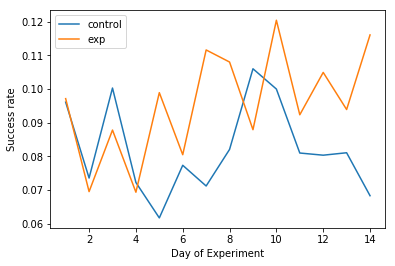

In [35]:
# data visualization
plt.plot(data['day'], data['control'])
plt.plot(data['day'], data['exp'])
plt.legend()

plt.xlabel('Day of Experiment')
plt.ylabel('Success rate');

In [36]:
sign_test(data['control'], data['exp'], 'less')

0.08978271484375001